# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. Hence as an example for 2 students:
12301230_3434343_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Tom Lieberum"
NAME2 = "Erik Jenner"
EMAIL = "tlieberum@outlook.de"
EMAIL2 = "erik.jenner99@gmail.com"


# Lab 2: Classification

### Machine Learning 1, September/October 2020

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

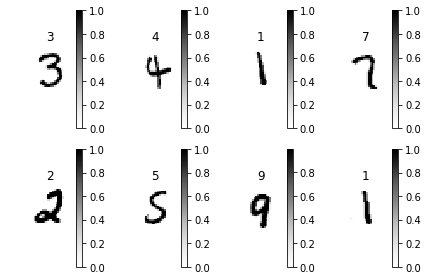

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



$\mathbf{OUR} \mathbf{ANSWERS}$

For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{1}{Z} \exp(\log q_j) = 1 - p_j = 1 - p_{t^{(n)}}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= -\frac{1}{Z} \exp(\log q_j) =  -p_j
\end{align}

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

$\mathbf{OUR}$ $\mathbf{ANSWERS}$

$
\mathbf{\delta}_j^q \frac{\partial \log q_j}{\partial W_{ij}} = 
\mathbf{\delta}_j^q \frac{\partial}{\partial W_{ij}} (\mathbf w_j^T \mathbf x + b_j) = 
\mathbf{\delta}_j^q \cdot x_i
$

In vector format:
$
\nabla_{\mathbf w_j} \mathcal L^{(n)} = \mathbf{\delta}_j^q \mathbf x^T
$



### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [50]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    
    ## MY CODE ##
    #print(x.shape) #, is (1, 784) or (784) depending on part of the exercise!
    #print(t.shape) #, is (1,)
    #print(w.shape) #, is (784, 10)
    #print(b.shape) #, is (10,)
    #print('\n######\n')
    
    # make sure x has consistent shape through part of the lab
    if len(x.shape) == 1:
        x = x[None,:]
    
    # compute log q
    log_q = x @ w + b # checked with for-loop implementation; seems correct
    
    # compute log_Z; use the log-sum-exp trick
    max_lq = np.max(log_q, axis=1)
    log_Z = max_lq + np.log(np.sum(np.exp(log_q - max_lq))) # checked with naive version; seems correct

    # compute log_p
    logp = log_q - log_Z
 
    # compute delta_q
    delta_q = -np.exp(logp) # = np.exp(log_q)/np.exp(log_Z), yields same value
    delta_q[np.arange(x.shape[0]), np.array(t, dtype=np.int32)] += 1
    
    # compute gradients
    dL_dw = x.T * delta_q[:,None,:] # checked with for-loop; seems correct

    dL_dw = np.mean(dL_dw, axis=0) # take batch mean
    
    dL_db = delta_q

    ## ##
    
    # here the statement contains logp[:,t] where logp is meant tas a matrix of shape 1x10
    
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()


In [51]:
# Hidden tests for efficiency

In [52]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [53]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.36129468949e-07
Finite difference error grad_b: 5.23511748692e-08


In [54]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-4`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [55]:
def sgd_iter(x_train, t_train, W, b):
    ## MY CODE ##
    idcs = np.random.permutation(x_train.shape[0])
    lr = 1e-4
    logp_train = 0
    
    for i, idx in enumerate(idcs):
        
        # get gradient
        logp, dL_dw, dL_db = logreg_gradient(x_train[idx], t_train[idx], W, b)
        try:
            logp = float(logp) # is a numpy array for some reason
        except:
            print(logp)
            raise ValueError
        
        # store logp
        logp_train += logp
        
        # update parameters
        W = W + lr * dL_dw
        b = b + lr * dL_db
        
        
        # some monitoring
        if (i+1)%10000 == 0:
            print('Processed {0} datapoints. Current logp = {1:1.3f}'.format(i+1, logp))
    
    # return average logp
    logp_train /= x_train.shape[0]
    
    ## ##
    
    return logp_train, W, b

In [56]:
# Hidden tests for efficiency

In [57]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

In [58]:

def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    
    ## MY CODE ##
    eps = 0.0019 # stopping criterion
    done = False
    epoch = 0
    
    logp_trains = []
    logp_valids = []
    
    while not done:
        
        # inc epoch ctr
        epoch += 1
        
        # store for stopping criterion
        old_w = w.copy()
        old_b = b.copy()
    
        # perform one sweep over the training set
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)
        logp_trains.append(float(logp_train))
        
        # evaluate on validation set
        logp_valid = 0
        for i in range(x_valid.shape[0]):
            log_q = x_valid[i][None,:] @ w + b
            
            # compute log_Z; use the log-sum-exp trick
            max_lq = np.max(log_q, axis=1)
            log_Z = max_lq + np.log(np.sum(np.exp(log_q - max_lq)))
            
            # compute log_p
            logp = (log_q - log_Z)[:,t_valid[i]].squeeze()
            logp_valid += logp
        
        logp_valid /= x_valid.shape[0]
        logp_valids.append(float(logp_valid))
        
        # if we stop updating significantly we will halt training.
        rmse = np.sqrt(np.mean((old_w-w)**2) + np.mean((old_b-b))**2)
        print('Epoch {0}: RMSE = {1:1.4f}, logp_valid = {2:1.3f}'.format(epoch, rmse, logp_valid))
        if rmse < eps:
            done = True
        
    ## ##

    plt.figure()
    plt.plot(np.arange(epoch), logp_trains, label='logp_train')
    plt.plot(np.arange(epoch), logp_valids, label='logp_valid')
    plt.legend()
    plt.grid()
    plt.ylabel('logp')
    plt.xlabel('epoch')
    plt.show()
    
    return w,b
    
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

Processed 10000 datapoints. Current logp = -1.675
Processed 20000 datapoints. Current logp = -1.354
Processed 30000 datapoints. Current logp = -1.267
Processed 40000 datapoints. Current logp = -0.699
Processed 50000 datapoints. Current logp = -1.041
Epoch 1: RMSE = 0.0283, logp_valid = -0.798
Processed 10000 datapoints. Current logp = -2.838
Processed 20000 datapoints. Current logp = -0.659
Processed 30000 datapoints. Current logp = -0.208


KeyboardInterrupt: 

In [15]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


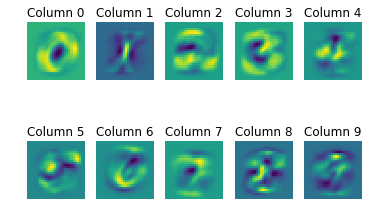

In [13]:
## MY CODE ##

plt.figure()

for j in range(w.shape[1]):
    
    col = w[:,j]
    plt.subplot(2,5,j+1)
    plt.title('Column {}'.format(j))
    plt.imshow(col.reshape(28,28))
    plt.axis('off')

## ##

**Describe in less than 100 words why these weights minimize the loss**

There are two opposing influences on the weights: they need to make the score high if the digit they match is shown but at the same time keep the score low otherwise. This means that the weight will be high if the corresponding pixel is often white for its digit compared to other digits. This explains why for e.g. 5, there are low weights in a horizontal region in the middle even though a 5 often has a bar somewhere in that region: apparently other digits (like 4) are even more likely to have white pixels there.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


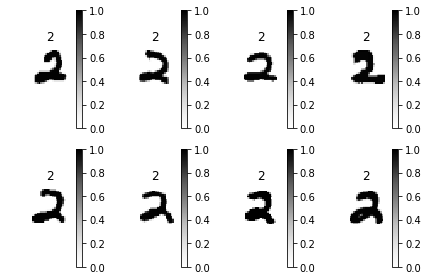

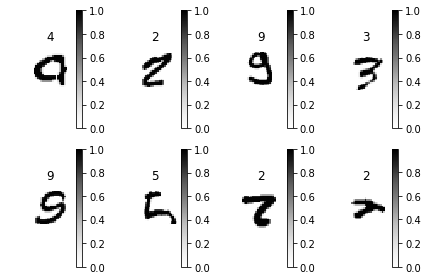

In [14]:
## MY CODE ##
log_p = np.zeros(x_valid.shape[0])
for i in range(x_valid.shape[0]):
    log_q = x_valid[i][None,:] @ w + b

    # compute log_Z; use the log-sum-exp trick
    max_lq = np.max(log_q, axis=1)
    log_Z = max_lq + np.log(np.sum(np.exp(log_q - max_lq)))

    # compute log_p
    log_p[i] = (log_q - log_Z)[:,t_valid[i]].squeeze()

# get easiest numbers
idcs = np.argsort(log_p)
easiest = x_valid[idcs][-8:]
easiest_targets = t_valid[idcs][-8:]
hardest = x_valid[idcs][:8]
hardest_targets = t_valid[idcs][:8]


# visualize easiest
plot_digits(easiest, 4, targets=easiest_targets, shape=(28,28))

# visualize hardest:
plot_digits(hardest, 4, targets=hardest_targets, shape=(28,28))
## ##

Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

Those results seem to make sense. If we look at the hard digits (lower two rows), there are some which would be even hard for a human to classify. What makes it hard is if a digit looks very similar to how a different digit would usually be written. For example the 4 at position (2,0) looks very much like a 0 and the 2 and position (3,2) could easily be a 7 as well.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

OUR ANSWERS:

They are equal (or almost equal) because we can treat $\mathbf h$ as the input $\mathbf x$ in our logistic regression case and then plug into the equations we derived in the first part.

Thus we get $\nabla_\mathbf b \mathcal L^{(n)} = \delta^q$ and $\nabla_{\mathbf w_j}\mathcal L^{(n)} = \delta^q_j \mathbf h^T$.

From the second term we can directly infer that $\frac{\partial \mathcal L^{(n)}}{\partial \mathbf W_{ij}} = \delta^q_j \mathbf h_i $

Computing $\delta^h$:

$
\delta^h = \sum_i\frac{\partial \mathcal L^{(n)}}{\partial \log q_i}\frac{\partial \log q_i}{\partial \mathbf h} = \sum_i \delta^q_i \mathbf w^T_i\\
\Rightarrow \delta^h_j = \sum_i\delta^q_i \mathbf W_{ji}
$


Computing the derivative w.r.t. $\mathbf a$:

$
\frac{\partial \mathcal L^{(n)}}{\partial a_j} = \frac{\partial \mathcal L^{(n)}}{\partial \mathbf h_j} \frac{\partial \mathbf h_j}{\partial a_j} = \delta^h_j \mathbf h_j (1-\mathbf h_j) \cdot 1 = \delta^h_j \mathbf h_j (1-\mathbf h_j)
$

Computing the derivative w.r.t. $\mathbf V$:

$
\frac{\partial \mathcal L^{(n)}}{\partial \mathbf v_j} = \frac{\partial \mathcal L^{(n)}}{\partial \mathbf h_j} \frac{\partial \mathbf h_j}{\partial \mathbf v_j} = \delta^h_j \mathbf h_j (1-\mathbf h_j) \mathbf x^T
$

From this we can derive that $\frac{\partial \mathcal L^{(n)}}{\partial\mathbf V_{ij}} = \delta^h_j \mathbf h_j (1-\mathbf h_j) \mathbf x_i $



## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

Finding the MAP solution is equivalent to finding the solution that maximizes the sum of the log-likelihood and the log-prior, which can be seen by taking the logarithm of Bayes theorem and considering that the logarithm is monotonically increasing.

For a Gaussian prior centered on 0, the log-prior has the form $-\alpha ||W||_F^2$, so we need to maximize $\mathcal{L} - \alpha ||W||_F^2$. We therefore effectively introduce an L2 regularization term. We can then use gradient ascent on the new objective (which just contains an additional term for the log-prior).

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [84]:
# Write all helper functions here


class MLP():
    
    def __init__(self):
        
        self.V = np.zeros((784,20))
        self.a = np.zeros(20)
        self.W = np.zeros((20,10))
        self.b = np.zeros(10)
        
        # Init weight tensors with glorot uniform
        limit_V = np.sqrt(6/(784+20))
        limit_W = np.sqrt(6/(20+10))
        
        self.V = np.random.uniform(-limit_V, limit_V, self.V.shape)
        self.W = np.random.uniform(-limit_W, limit_W, self.W.shape)

        
    def forward(self, x):
        
        # compute activation
        self.act = x @ self.V + self.a
        
        # compute sigmoid
        # use trick to avoid overflow
        max_act = np.max(-self.act)
        self.h = np.exp(-max_act) / (np.exp(-max_act) + np.exp(-self.act-max_act))
        #self.h = 1 / (1 + np.exp(-self.act))
        
        # compute logq and logZ
        log_q = self.h @ self.W + self.b
        max_lq = np.max(log_q, axis=1)
        log_Z = max_lq + np.log(np.sum(np.exp(log_q-max_lq[:,None]), axis=1))
        
        # compute log_p
        log_p = log_q - log_Z[:,None]

        return log_p
        
    
    def backward(self, x, log_p, targets):
        '''
        Compute gradients from log_p and the correct target values
        '''
        
        # compute delta_q
        delta_q = -np.exp(log_p) 
        delta_q[np.arange(x.shape[0]), np.array(targets, dtype=np.int32)] += 1
        
        # compute delta_h
        delta_h = np.einsum('hi,ji -> hj', delta_q, self.W) # h is the batch index
        
        if len(delta_h.shape) == 1:
            delta_h = delta_h[None,:]
        
        # compute gradients
        self.dL_db = delta_q
        self.dL_dW = np.einsum('ij,ik -> ijk', self.h, delta_q)
        self.dL_da = delta_h * self.h * (1 - self.h)
        self.dL_dV = np.einsum('...j,...k->...jk', x, (delta_h * self.h * (1-self.h)))
        
        # take batch means
        self.dL_db = np.mean(self.dL_db, axis = 0)
        self.dL_dW = np.mean(self.dL_dW, axis = 0)
        self.dL_da = np.mean(self.dL_da, axis = 0)
        self.dL_dV = np.mean(self.dL_dV, axis = 0)
        
        return self.dL_db, self.dL_dW, self.dL_da, self.dL_dV

    def gradient_step(self, lr):
        '''
        Performs one step of stochastic gradient descent with learning rate lr
        '''
        
        self.b = self.b + lr * self.dL_db
        self.W = self.W + lr * self.dL_dW
        self.a = self.a + lr * self.dL_da
        self.V = self.V + lr * self.dL_dV
        


def mlp_sgd_iter(model, x, t, lr=1e-3, update=True, batch_size=1):
    '''
    Performs one sweep over a set, updating after each point IFF update is True.
    '''
    
    
    # return mean of log_p
    avg_log_p = 0
    
    for i in range(0,x.shape[0],batch_size):
        
        # get batch
        x_batch = x[i:i+batch_size,:]
        t_batch = t[i:i+batch_size]        
        
        # forward pass
        log_p = model.forward(x_batch)
        
        if update:
            # backward pass
            gradients = model.backward(x_batch, log_p, t_batch)
            
            # update parameters
            model.gradient_step(lr)

        # store logp
        avg_log_p += np.mean(log_p[np.arange(batch_size),t_batch]) # take batch mean
        
    
    # return average logp of dataset
    avg_log_p /= x.shape[0] // batch_size
    
    return avg_log_p
    

def train(model_class, num_epochs, lr, x_train, t_train, x_valid, t_valid, batch_size):
    '''
    Trains a model of class model_class for num_epochs epochs with a learning rate of lr
    '''
    
    # inst. model
    model = model_class()
    
    # shuffle data
    train_idcs = np.random.permutation(x_train.shape[0])
    x_train = x_train[train_idcs]
    t_train = t_train[train_idcs]
    
    valid_idcs = np.random.permutation(x_valid.shape[0])
    x_valid = x_valid[valid_idcs]
    t_valid = t_valid[valid_idcs]
    
    # store for plotting
    logp_trains = []
    logp_valids = []
    weights = [] # store weights of first layer after 0,4,9 epochs
    
    for epoch in range(num_epochs):
        
        if epoch in [0,4,9]:
            print('Storing weights after {} epochs..'.format(epoch))
            weights.append(model.V.copy())
        
        # go over train set and update
        logp_train = mlp_sgd_iter(model, x_train, t_train, lr=lr, batch_size=batch_size)
        logp_trains.append(logp_train)
        
        # eval on validation set
        logp_valid = mlp_sgd_iter(model, x_valid, t_valid, update=False, batch_size=batch_size)
        logp_valids.append(logp_valid)

        print('Epoch {0}: train score: {1:1.4f}; valid score: {2:1.4f}'.format(epoch+1, logp_train, logp_valid))
    
    return model, weights, logp_trains, logp_valids
    

In [85]:
# Hidden tests for efficiency

In [86]:
'''
Gradient Checking Code -- Ignore for grading
'''

# scalar, 10 X 768  matrix, 10 X 1 vector
W = np.random.rand(20,10)
b = np.random.rand(10)
V = np.random.uniform(-np.sqrt(6/804),np.sqrt(6/804), (784,20))
a = np.random.rand(20)

mlp = MLP()


def func(W):
    
    # store old params
    old_params = mlp.W.copy()
    
    # perform computation
    mlp.W = W.reshape(20, 10)
    logpt = mlp.forward(x_train[0:1])
    
    #reset weights
    mlp.W = old_params
    return logpt[0, t_train[0]]

def grad(W):

    # store old params
    old_params = mlp.W.copy()
    
    # perform computation
    mlp.W = W.reshape(20, 10)
    logpt = mlp.forward(x_train[0:1])
    dL_db, dL_dW, dL_da, dL_dV = mlp.backward(x_train[0:1], logpt, t_train[0:1])
    
    #reset weights
    mlp.W = old_params
    return dL_dW.flatten()

finite_diff_error = check_grad(func, grad, W.flatten())
print('Finite difference error grad_w:', finite_diff_error)

####

def func(b):
    
    # store old params
    old_params = mlp.b.copy()
    
    # perform computation
    mlp.b = b.reshape(10)
    logpt = mlp.forward(x_train[0:1])
    
    #reset weights
    mlp.b = old_params
    return logpt[0, t_train[0]]

def grad(b):

    # store old params
    old_params = mlp.b.copy()
    
    # perform computation
    mlp.b = b.reshape(10)
    logpt = mlp.forward(x_train[0:1])
    dL_db, dL_dW, dL_da, dL_dV = mlp.backward(x_train[0:1], logpt, t_train[0:1])
    
    #reset weights
    mlp.b = old_params
    return dL_db.flatten()

finite_diff_error = check_grad(func, grad, b.flatten())
print('Finite difference error grad_b:', finite_diff_error)

####

def func(V):
    
    # store old params
    old_params = mlp.V.copy()
    
    # perform computation
    mlp.V = V.reshape(784,20)
    logpt = mlp.forward(x_train[0:1])
    
    #reset weights
    mlp.V = old_params
    
    return logpt[0, t_train[0]]

def grad(V):

    # store old params
    old_params = mlp.V.copy()
    
    # perform computation
    mlp.V = V.reshape(784,20)
    logpt = mlp.forward(x_train[0:1])
    dL_db, dL_dW, dL_da, dL_dV = mlp.backward(x_train[0:1], logpt, t_train[0:1])
    
    #reset weights
    mlp.V = old_params
    return dL_dV.flatten()

finite_diff_error = check_grad(func, grad, V.flatten())
print('Finite difference error grad_v:', finite_diff_error)

####

def func(a):
    
    # store old params
    old_params = mlp.a.copy()
    
    # perform computation
    mlp.a = a.reshape(20)
    logpt = mlp.forward(x_train[0:1])
    
    #reset weights
    mlp.a = old_params
    return logpt[0, t_train[0]]

def grad(a):

    # store old params
    old_params = mlp.a.copy()
    
    # perform computation
    mlp.a = a.reshape(20)
    logpt = mlp.forward(x_train[0:1])
    dL_db, dL_dW, dL_da, dL_dV = mlp.backward(x_train[0:1], logpt, t_train[0:1])
    
    #reset weights
    mlp.a = old_params
    return dL_da.flatten()

finite_diff_error = check_grad(func, grad, a.flatten())
print('Finite difference error grad_a:', finite_diff_error)


Finite difference error grad_w: 3.07401759894e-07
Finite difference error grad_b: 5.75673076624e-08
Finite difference error grad_v: 7.70503821044e-07
Finite difference error grad_a: 5.89424233746e-08


In [87]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.

# 

## MY CODE ##


lr_list = [1e-2, 1e-3, 1e-4]
num_epochs = 10
batch_size = 50

models = []
logp_train_list = []
logp_valid_list = []
weights_list = []


for lr in lr_list:
    print('\n#########\n#########\n')
    print('Now training with lr {}!'.format(lr))
    
    # train model for num_epochs epochs
    model, weights, logp_trains, logp_valids = train(MLP, num_epochs, lr, x_train, t_train, x_valid, t_valid, batch_size)
    
    # save results
    models.append(model)
    weights_list.append(weights)
    logp_train_list.append(logp_trains)
    logp_valid_list.append(logp_valids)

# Split cell here so we don't have to retrain every time we change the plots

    
##


#########
#########

Now training with lr 0.01!
Storing weights after 0 epochs..
Epoch 1: train score: -1.9571; valid score: -1.6305
Epoch 2: train score: -1.3979; valid score: -1.1946
Epoch 3: train score: -1.0561; valid score: -0.9362
Epoch 4: train score: -0.8490; valid score: -0.7767
Storing weights after 4 epochs..
Epoch 5: train score: -0.7176; valid score: -0.6732
Epoch 6: train score: -0.6299; valid score: -0.6023
Epoch 7: train score: -0.5682; valid score: -0.5513
Epoch 8: train score: -0.5229; valid score: -0.5131
Epoch 9: train score: -0.4883; valid score: -0.4835
Storing weights after 9 epochs..
Epoch 10: train score: -0.4612; valid score: -0.4599

#########
#########

Now training with lr 0.001!
Storing weights after 0 epochs..
Epoch 1: train score: -2.3508; valid score: -2.2561
Epoch 2: train score: -2.2010; valid score: -2.1557
Epoch 3: train score: -2.1182; valid score: -2.0817
Epoch 4: train score: -2.0485; valid score: -2.0140
Storing weights after 4 epochs..
Epoch 5

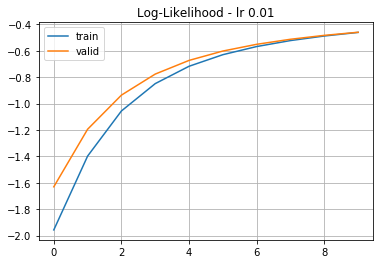

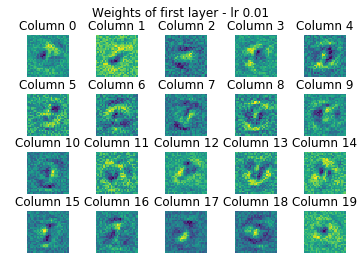

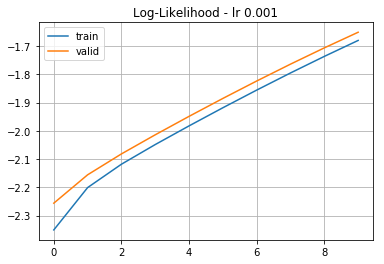

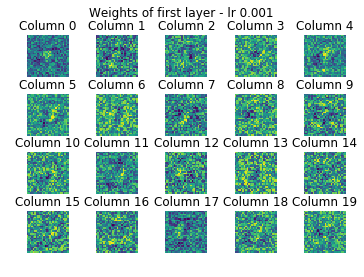

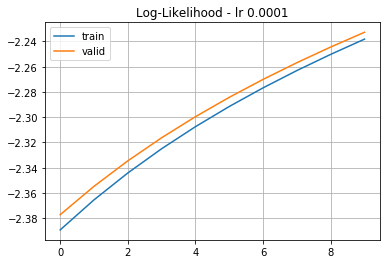

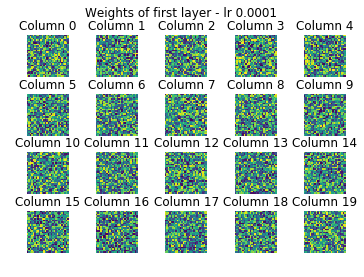

In [88]:
## Continuation of Cell above

for i in range(3):
    
    plt.figure()
    plt.title('Log-Likelihood - lr {}'.format(lr_list[i]))
    plt.plot(logp_train_list[i], label='train')
    plt.plot(logp_valid_list[i], label='valid')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.subplots_adjust(hspace=0.4)
    for j in range(models[i].V.shape[1]):
    
        col = models[i].V[:,j]
        plt.subplot(4,5,j+1)
        plt.title('Column {}'.format(j))
        plt.imshow(col.reshape(28,28))
        plt.axis('off')
    
    plt.suptitle('Weights of first layer - lr {}'.format(lr_list[i]))
    plt.show()
##


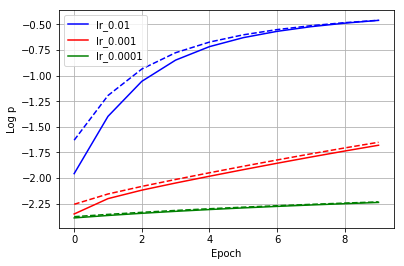

In [89]:
# plot the train and validation logp for all three learning rates in one figure

## MY CODE ##
colors = ['b', 'r', 'g']

plt.figure()
for i in range(3):
    plt.plot(logp_train_list[i], color=colors[i], label='lr_{}'.format(lr_list[i]))
    plt.plot(logp_valid_list[i], color=colors[i], linestyle='--')

plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Log p')
plt.show()

## ##
    

The dashed lines correspond to the validation, the solid lines to the training performance.

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

OUR ANSWERS:

lr 0.01: A high learning rate means that we might take too large steps, skipping over local minima in the loss lanscape. This is reflected in the more erratic curve for validation and training loss.

lr 0.001: A learning rate this is approximately right will quickly find a local optimum and converge to it (up to an error term)

lr 0.0001: A small learning rate means that we are not skipping over local minima, resulting in a smooth training curve. However, we make only small adjustment to the weights in each step, resulting in slower convergence than in the above cases.

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

Best model was obtained with lr 0.01


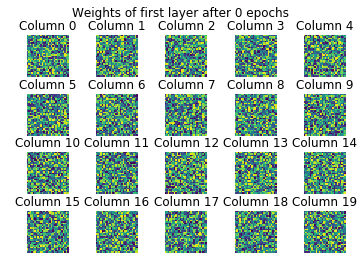

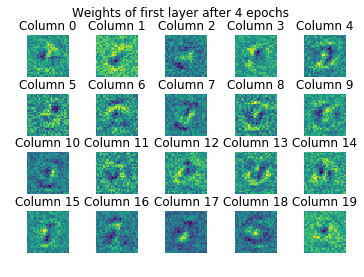

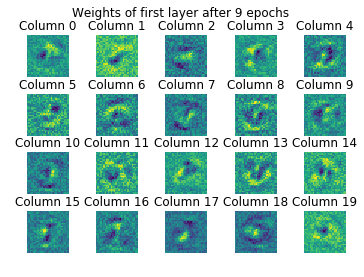

In [90]:
# Plot the weights of the first layer for the best model 

## MY CODE ## 

# Get best model
best_model = 0
best_logp_valid = -np.inf

for i in range(3):
    if logp_valid_list[i][-1] > best_logp_valid:
        best_model = i
        best_logp_valid = logp_valid_list[i][-1]

print('Best model was obtained with lr {}'.format(lr_list[best_model]))

# display weights of first layer for the best model after 0, 4 and 9 epochs
epochs = [0,4,9]
for i in range(3):
    plt.figure()
    plt.subplots_adjust(hspace=0.4)
    for j in range(models[best_model].V.shape[1]):
    
        col = weights_list[best_model][i][:,j]
        plt.subplot(4,5,j+1)
        plt.title('Column {}'.format(j))
        plt.imshow(col.reshape(28,28))
        plt.axis('off')
    plt.suptitle('Weights of first layer after {} epochs'.format(epochs[i]))    
    plt.show()

## ##

YOUR ANSWER HERE

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

OUR ANSWERS:

For the ReLU we get the following derivative:
$$f'(x) = \begin{cases} 0,\hspace{2mm} &x\leq 0\\ 1, &x>0 \end{cases}$$

For the tanh, we use that the derivative of sinh$(x)$ is cosh$(x)$ and vice versa, and that the tanh is given by $$\tanh(x) = \frac{\sinh(x)}{\cosh(x)}$$

With that we can derive

$$
\tanh'(x) = \frac{\cosh(x)}{\cosh(x)} - \frac{\sinh^2(x)}{\cosh^2(x)} = \frac{\cosh^2(x) - \sinh^2(x)}{\cosh^2(x)} = \frac{1}{\cosh^2(x)} = \frac{4}{(e^x + e^{-x})^2}
$$

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

Ideally we want to get a strong gradient, which translates into our activation function not saturating to quickly for activations that are very large (positive or negative).


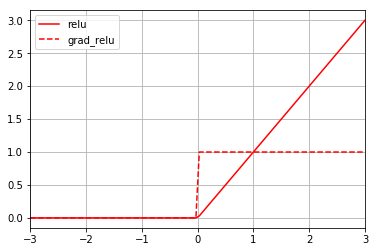

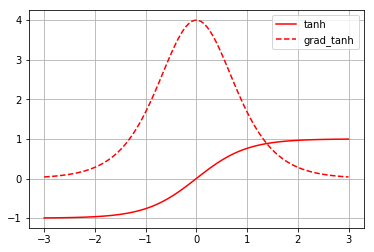

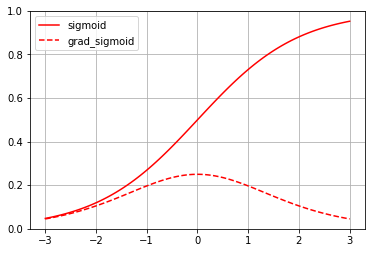

In [65]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.

## MY CODE ##

def ReLU(x):
    x[x<0] = 0
    return x 

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def grad_relu(x):
    return (x > 0) * np.ones_like(x)

def grad_tanh(x):
    return 4 / (np.cosh(x)**2)

def grad_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))


x = np.linspace(-3,3,100)
# plot relu
plt.figure()
plt.plot(x, ReLU(x.copy()), color='r', label='relu')
plt.plot(x, grad_relu(x), color='r', linestyle='--', label='grad_relu')
plt.xlim(-3,3)
plt.grid()
plt.legend()
plt.show()

# plot tanh
plt.figure()
plt.plot(x, tanh(x), color='r', label='tanh')
plt.plot(x, grad_tanh(x), color='r', linestyle='--', label='grad_tanh')
plt.grid()
plt.legend()
plt.show()

# plot sigmoid
plt.figure()
plt.plot(x, sigmoid(x), color='r', label='sigmoid')
plt.plot(x, grad_sigmoid(x), color='r', linestyle='--', label='grad_sigmoid')
plt.grid()
plt.legend()
plt.show()
## ##

Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

Tanh has the strongest gradient for inputs in the center but saturates quickly, whereas sigmoid has a relatively weak gradient. ReLU has a constant positive gradient for all inputs larger than 0, so that we would choose that one, despite the risk of a few neurons 'dying' (i.e. putting out 0 and not recovering because the gradient is 0 for inputs smaller than 0.)

In [ ]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))